# Split mini representative dataset

In [1]:
from createCSV import TrainTest
import config

if __name__ == "__main__":
    csv = TrainTest(
        base_dir = config.BASE_DIR,
        all_csv = config.ALL_CSV,
        train_csv = config.TRAIN_CSV,
        test_csv = config.TEST_CSV,
        label_column = config.LABEL_COLUMN,
        test_size = config.TEST_SIZE,
        seed = config.SEED)
    csv.set_all_seeds()
    csv.df()

Train set length:
755
Test set length:
245
Train set label distribution:
0    398
1    357
Name: label, dtype: int64
Test set label distribution:
1    143
0    102
Name: label, dtype: int64


In [2]:
from createCSV import TrainVal
import config

if __name__ == "__main__":
    csv1 = TrainVal(
        orig_train_csv = config.TRAIN_CSV,
        train_csv = config.TRAIN_CSV_1,
        val_csv = config.VAL_CSV_1,
        label_column = config.LABEL_COLUMN,
        val_size = config.VAL_SIZE,
        seed = config.SEED)
    csv1.set_all_seeds()
    csv1.df()

Original train set length:
755
New train set length and first n rows:
613
                                           file_name  label   parcel_id
8   22-0249080_F796528C401EECCDE0530EEE260A12DE.jpeg      0  22-0249080
9   22-0249080_F796528C45EEECCDE0530EEE260A12DE.jpeg      0  22-0249080
16  22-0249181_F7F34037674E9508E0530EEE260A6CC9.jpeg      0  22-0249181
17  22-0249181_F7F3403767749508E0530EEE260A6CC9.jpeg      0  22-0249181
18  22-0249181_F7F3403767E39508E0530EEE260A6CC9.jpeg      0  22-0249181
Val set length and first n rows:
142
                                          file_name  label   parcel_id
0  22-0248171_F796528C3E03ECCDE0530EEE260A12DE.jpeg      0  22-0248171
1  22-0248171_F796528C3E05ECCDE0530EEE260A12DE.jpeg      0  22-0248171
2  22-0248171_F796528C4450ECCDE0530EEE260A12DE.jpeg      0  22-0248171
3  22-0248171_F796528C4451ECCDE0530EEE260A12DE.jpeg      0  22-0248171
4  22-0248171_F796528C4453ECCDE0530EEE260A12DE.jpeg      0  22-0248171
Train set label distribution:
1

In [15]:
from torchvision.models import vgg16, VGG16_Weights

weights = VGG16_Weights.IMAGENET1K_V1
preprocess_transform = weights.transforms()

preprocess_transform

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

# Train model on mini representative dataset

In [1]:
# Train model
from model import NN
from customDataModule import CustomDataModule
import config
import pytorch_lightning as pl
from lightning.pytorch.loggers import TensorBoardLogger
from pytorch_lightning.loggers import CSVLogger
from lightning.pytorch import seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint
import torch
import torchvision.models as models
import torch.nn as nn

seed_everything(
    42, workers=True
)  # By setting workers=True in seed_everything(), Lightning derives unique seeds across all dataloader workers and processes for torch, numpy and stdlib random number generators. When turned on, it ensures that e.g. data augmentations are not repeated across workers.


callbacks = [ModelCheckpoint(
    save_top_k=1, mode='min', monitor="val_loss")]  # save top 1 model 


if __name__ == "__main__":
    
    pytorch_model = models.vgg16(weights='VGG16_Weights.DEFAULT')
    
    logger = TensorBoardLogger("tb_logs", name="view") # tb_logs is the folder, name is the name of the experiment/model
    logger2 = CSVLogger(save_dir="logs/", name="view")
    
    model = NN(
        model=pytorch_model,
        input_shape=config.INPUT_SHAPE,
        num_classes=config.NUM_CLASSES,
        learning_rate=config.LEARNING_RATE,
    )  # .to(device)
    dm = CustomDataModule(
        data_dir=config.DATA_DIR,
        train_csv=config.TRAIN_CSV_1,
        val_csv=config.VAL_CSV_1,
        test_csv=config.TEST_CSV,
        batch_size=config.BATCH_SIZE,
        num_workers=config.NUM_WORKERS,
    )
    
    trainer = pl.Trainer(
        logger=[logger2, logger],
        accelerator=config.ACCELERATOR,
        devices=config.DEVICES,
        min_epochs=config.MIN_EPOCHS,
        max_epochs=config.MAX_EPOCHS,
        deterministic=config.DETERMINISTIC,
        callbacks=callbacks
    )
      # deterministic ensures random seed reproducibility

    trainer.fit(model, dm)  # it will automatically know which dataloader to use

# A general place to start is to set num_workers equal to the number of CPU cores on that machine. You can get the number of CPU cores in python using os.cpu_count(), but note that depending on your batch size, you may overflow RAM memory.


Global seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/view
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name            | Type             | Params
------------------------------------------------------
0  | model           | VGG              | 134 M 
1  | loss_fn         | CrossEntropyLoss | 0     
2  | train_acc       | BinaryAccuracy   | 0     
3  | val_acc         | BinaryAccuracy   | 0     
4  | test_acc        | BinaryAccuracy   | 0     
5  | train_recall    | BinaryRecall     | 0     
6  | val_recall      | BinaryRecall     | 0     
7  | train_precision | BinaryPrecision  | 0     
8  | val_precision   | BinaryPrecision  | 0     
9  | train_f1score   | BinaryF1Score    | 0     
10 | val_f1score     | BinaryF1Score    | 0     
------------------------------------------------------
8.2 K     Trainable params
134 M     Non-trainable p

C:\Users\kaspe\.conda\envs\LBST\lib\site-packages\pytorch_lightning\loops\fit_loop.py:280: PossibleUserWarning: The number of training batches (20) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0: 100%|██████████| 20/20 [00:09<00:00,  2.04it/s, v_num=0_34]
Validation: 0it [00:00, ?it/s]
Epoch 1: 100%|██████████| 20/20 [00:10<00:00,  1.96it/s, v_num=0_34, train_loss=0.664, train_accuracy=0.615, train_recall=0.592, train_precision=0.606, train_f1score=0.560]
Validation: 0it [00:00, ?it/s]
Epoch 2: 100%|██████████| 20/20 [00:10<00:00,  1.98it/s, v_num=0_34, train_loss=0.573, train_accuracy=0.718, train_recall=0.781, train_precision=0.724, train_f1score=0.732]
Validation: 0it [00:00, ?it/s]
Epoch 3: 100%|██████████| 20/20 [00:09<00:00,  2.02it/s, v_num=0_34, train_loss=0.548, train_accuracy=0.736, train_recall=0.698, train_precision=0.806, train_f1score=0.716]
Validation: 0it [00:00, ?it/s]
Epoch 4: 100%|██████████| 20/20 [00:09<00:00,  2.02it/s, v_num=0_34, train_loss=0.493, train_accuracy=0.768, train_recall=0.777, train_precision=0.770, train_f1score=0.766]
Validation: 0it [00:00, ?it/s]
Epoch 5: 100%|██████████| 20/20 [00:09<00:00,  2.05it/s, v_num=0_34, train_loss=0.50

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 20/20 [00:15<00:00,  1.31it/s, v_num=0_34, train_loss=0.455, train_accuracy=0.786, train_recall=0.787, train_precision=0.795, train_f1score=0.773]


In [2]:
model

NN(
  (model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): MaxPo

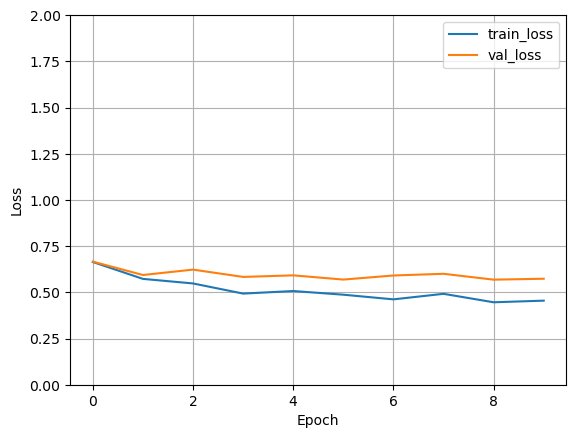

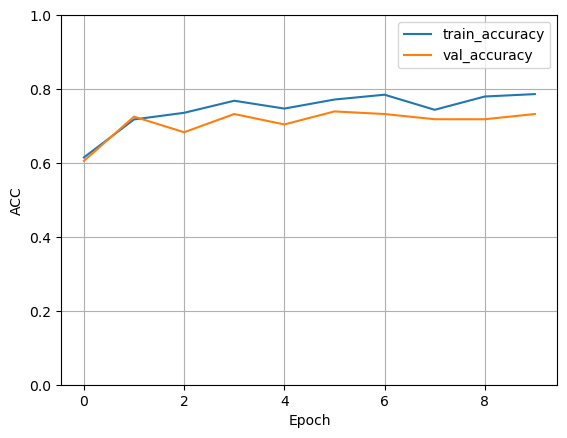

In [3]:
from plot_loss_and_acc import *
plot_loss_and_acc(trainer.logger.log_dir, loss_ylim=(0.0, 2.0), acc_ylim=(0.0, 1.0))

In [4]:
path = trainer.checkpoint_callback.best_model_path
print(path)

logs/view\version_0\checkpoints\epoch=8-step=180.ckpt


In [5]:
trainer.validate(model=model, datamodule=dm, ckpt_path=path)

Restoring states from the checkpoint path at logs/view\version_0\checkpoints\epoch=8-step=180.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Loaded model weights from the checkpoint at logs/view\version_0\checkpoints\epoch=8-step=180.ckpt


Validation DataLoader 0: 100%|██████████| 5/5 [00:01<00:00,  3.42it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.7183098793029785     │
│        val_f1score        │    0.22523806989192963    │
│         val_loss          │    0.5684890747070312     │
│       val_precision       │    0.3239436745643616     │
│        val_recall         │    0.17605634033679962    │
└───────────────────────────┴───────────────────────────┘

[{'val_loss': 0.5684890747070312,
  'val_accuracy': 0.7183098793029785,
  'val_recall': 0.17605634033679962,
  'val_precision': 0.3239436745643616,
  'val_f1score': 0.22523806989192963}]

In [5]:
trainer.test(model=model, datamodule=dm, ckpt_path=path)

NameError: name 'trainer' is not defined

In [7]:
lightning_model = NN.load_from_checkpoint(
    path, model=pytorch_model)
lightning_model.eval();

In [19]:
from customDataModule import CustomDataModule
import config
if __name__ == "__main__":
    
    test_dm = CustomDataModule(
        data_dir=r"C:/Users/kaspe/OneDrive - Aarhus Universitet/Skrivebord/BI/4. semester/Data/LBST/all",
        train_csv=r"",
        val_csv=r"",
        test_csv=r"C:/Users/kaspe/OneDrive - Aarhus Universitet/Skrivebord/BI/4. semester/Data/LBST/test_set.csv",
        batch_size=config.BATCH_SIZE,
        num_workers=config.NUM_WORKERS,
        )

In [21]:
test_dm

In [10]:
test_dm.test_dataloader()

AttributeError: 'CustomDataModule' object has no attribute 'test_set'

In [15]:
test_dataloader = dm.val_dataloader() # The test dataloader is used as example here

#test_dataloader = test_dm.test_dataloader()

all_true_labels = []
all_predicted_labels = []
for batch in test_dataloader:
    features, labels = batch
    
    with torch.no_grad():
        logits = lightning_model(features)

    predicted_labels = torch.argmax(logits, dim=1)
    all_predicted_labels.append(predicted_labels)
    all_true_labels.append(labels)
    
all_predicted_labels = torch.cat(all_predicted_labels)
all_true_labels = torch.cat(all_true_labels)

Global seed set to 42


NameError: name 'dm' is not defined

In [9]:
all_predicted_labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1,
        1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,
        1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1])

In [11]:
all_true_labels

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [10]:
test_acc = torch.mean((all_predicted_labels == all_true_labels).float())
print(f'Test accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)')

Test accuracy: 0.7183 (71.83%)


In [38]:
import torchmetrics
confmat = torchmetrics.ConfusionMatrix(task = 'binary')
cm = confmat(all_predicted_labels, all_true_labels)
cm

tensor([[77, 17],
        [23, 25]])

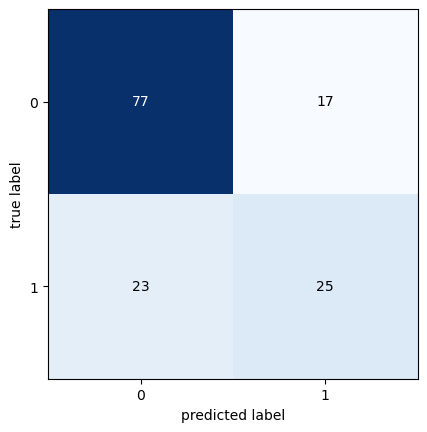

In [48]:
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

fig, ax = plot_confusion_matrix(conf_mat=cm.numpy(),
                                   hide_spines=False,
                                   hide_ticks=False,
                                   figsize=None,
                                   cmap=None,
                                   colorbar=False,
                                   show_absolute=True,
                                   show_normed=False,
                                   norm_colormap=None,
                                   class_names=None,
                                   figure=None,
                                   axis=None,
                                   fontcolor_threshold=0.5,)
plt.show()

In [9]:
model

NN(
  (model): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): MaxPo